<a href="https://colab.research.google.com/github/aubreymoore/crb-damage-detector-colab/blob/main/detect_and_annotate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# detect_and_annotate.ipynb

NOTE: The following documentation is already slightly out of date.
Please visit https://github.com/aubreymoore/crb-damage-detector-colab before running this notebook for the first time.

This Colab Jupyter notebook runs a custom YOLOv8 object detector which scans images to find three object classes: live coconut palms, dead coconut palms and v-shaped cuts symptomatic of damage caused by coconut rhinoceros beetle, *Oryctes rhinoceros*.

IMPORTANT: Shortly after the MAIN PROGRAM section begins executing, a BROWSE button will appear below the active cell to allow you to upload single file of input data from your loacal machine to Colab.

**Note that Colab will just sit there and not do anything until you have entered a path to a test file of URLs or a ZIP file of images on your local machine.** [Click here to scroll down to the "Browser" button.](#scrollTo=5zSjfTXvIv2q&line=1&uniqifier=1)

You may choose between 2 options:
* A TEXT file (\*.txt) containing URLs for images to be scanned. One URL per line. (This is the most efficient option.)
* A ZIP file (\*.zip) containing images to be scanned.


Test data are available in a companion GitHub repository at https://github.com/aubreymoore/crb-damage-detector-colab. To use the test data, download it to your local computer it as a [ZIP file](https://github.com/aubreymoore/crb-damage-detector-colab/archive/refs/heads/main.zip) and unzip it. If you have **git** installed, you can clone the repo as an alternative. The TEXT file or ZIP file to be uploaded to Colab will be found in the repository's **data** folder.

To scan images, select **Runtime | Run all** on the main menu.
Results will be in a temporary OUTPUT folder which you can access using the **File browser** in the left Colab panel.

When image scanning is complete, the OUTPUT folder will be compressed into a single ZIP file and automatically downloaded to your computer.

### TODO

- [ finished 2024-10-19] Reduce size of images in the companion GH repo to max dimension of 960px
- [ ] Copy current trained model to companion GH repo
- [ ] Copy this Jupyter notebook to companion GH repo
- [ ] Add confidence values to bounding box labels.
- [ ] Add database to OUTPUT folder
- [ ] Extract GPS coordinates from image files
- [ ] Figure out how to use URLs to access images stored on OneDrive (Sharepoint)

# Load Python packages which are not preinstalled by Colab

In [5]:
%pip install ultralytics -q
%pip install supervision -q
%pip install imutils -q
%pip install icecream -q
%pip install ipython-autotime -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.4 MB/s eta 0:00:00


# Import modules

In [6]:
import cv2
import supervision as sv
from ultralytics import YOLO
import imutils
import glob
import os
import shutil
from skimage import io
from icecream import ic
from google.colab import files
# ultralytics.checks()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Load cell timer

In [ ]:
%load_ext autotime

# Define functions

In [9]:
def upload_model_weights():
  '''
  Upload model weights from GitHub repo to **weights.pt** only if this file does not already exist.
  '''
  !wget -nc https://github.com/aubreymoore/code-for-CRB-damage-ai/raw/refs/heads/main/models/3class/train5/weights/best.pt -O weights.pt

# upload_model_weights()

In [8]:
def load_model_weights():
  model = YOLO('weights.pt')

In [ ]:
def create_input_folder():
  if not os.path.exists('INPUT'):
    os.makedirs('INPUT')

# create_input_folder()

In [ ]:
def create_output_folder():
  if not os.path.exists('OUTPUT'):
    os.makedirs('OUTPUT')

# create_output_folder()

In [ ]:
def run_garbage_disposal():
  '''
  Delete any data files left over from the last run.
  Note that the model is not removed.
  '''
  shutil.rmtree('mydata', ignore_errors=True)
  shutil.rmtree('OUTPUT', ignore_errors=True)
  try:
    os.remove('OUTPUT.zip')
  except:
    pass

# run_garbage_disposal()

# Upload images (\*.zip) or list of URLs (\*.txt)

When this cell runs, a **Browse** button will appear beneath it.
Click on the button and navigate to the file you wan to upload.
If you have downloaded the example data from the companion GitHub repo, try
uploading something like **/home/aubrey/Desktop/crb-damage-detector-colab/data/urls.txt** or **/home/aubrey/Desktop/crb-damage-detector-colab/data/resized.zip**.


In [ ]:
def upload_and_unpack_zip_or_txt():

  uploaded = files.upload(target_dir='INPUT')
  filename = list(uploaded.keys())[0]

  urls = None
  image_file_dir = None

  if filename.endswith('.txt'):
    input_mode = 'text'
    with open(filename, 'r') as f:
      urls = f.read().splitlines()
  elif filename.endswith('.zip'):
    input_mode = 'zip'
    !unzip -q $filename -d INPUT
    image_file_dir = f'INPUT/{filename}'.replace('.zip', '')
    ic(image_file_dir)
  else:
    raise ValueError('INPUT file must be *.txt or *.zip.')
  return input_mode, urls, image_file_dir

# input_mode, urls, image_file_dir = upload_and_unpack_zip_or_txt()
# ic(input_mode)
# ic(urls)
# ic(image_file_dir)

In [ ]:
def get_input_file_list():
  return glob.glob(f'INPUT/**/*', recursive=True)

# get_input_file_list()

File ‘weights.pt’ already there; not retrieving.

0: 736x960 11 lives, 2 vcuts, 340.1ms
Speed: 6.2ms preprocess, 340.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 960)


ic| detections: Detections(xyxy=array([[     288.29,      324.56,      401.81,      516.99],
                       [     66.051,      402.18,      165.17,      580.41],
                       [     379.41,      255.74,       523.7,      518.62],
                       [     511.93,      238.53,      632.35,      477.55],
                       [     814.12,      420.91,      879.73,      555.76],
                       [     181.74,      348.19,      280.32,      553.72],
                       [     483.13,      344.48,      584.15,      528.43],
                       [     616.46,      264.03,      758.95,      432.33],
                       [     561.47,       333.4,      784.45,      560.56],
                       [     717.89,      364.68,      854.33,      522.68],
                       [     225.73,      347.52,      239.22,         368],
                       [      441.3,      254.24,      456.52,      282.13],
                       [     125.05,      427.71,      216.9

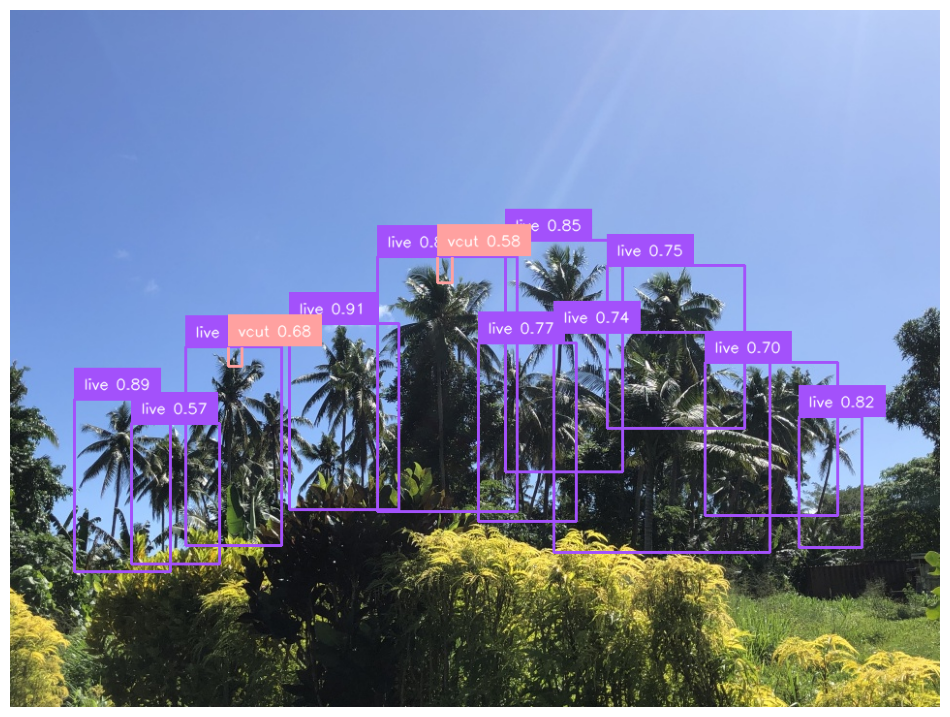

In [42]:
def detect_objects(image, model, box_annotator, label_annotator, csv_sink):
  '''
  detect objects in and image
  returns an annotated image
  '''
  results = model(image)[0]
  detections = sv.Detections.from_ultralytics(results)
  # ic(detections)
  annotated_image = box_annotator.annotate(image, detections=detections)
  labels = [f"{model.model.names[class_id]} {confidence:.2f}" for class_id, confidence in zip(detections.class_id, detections.confidence)]
  annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
  return detections, annotated_image

csv_sink = sv.CSVSink('detections.csv')
csv_sink.open()

upload_model_weights()
model = YOLO('weights.pt')
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()


url = 'https://github.com/aubreymoore/crb-damage-detector-colab/blob/main/data/Vanuatu_July_2022_Sulav/resized-images/IMG_0532.JPG?raw=true'
image = imutils.url_to_image(url)
detections, annotated_image = detect_objects(image, model, box_annotator, label_annotator, csv_sink)
ic(detections)
sv.plot_image(annotated_image)

csv_sink.append(detections, custom_data=getattr(detections, 'data', {}))  # Pass detections.data as custom_data

csv_sink.close()




# MAIN PROGRAM

In [ ]:
# Clear data files from previous run
run_garbage_disposal()

# If model is not defined upload weights from trained model and load them
try:
  model
except NameError:
  upload_model_weights()
  model = YOLO('weights.pt')

create_input_folder()
create_output_folder()

input_mode, urls, image_file_dir = upload_and_unpack_zip_or_txt()
ic(input_mode)
ic(urls)
ic(image_file_dir)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

if input_mode == 'text':
  for url in urls:
    try:
      image = imutils.url_to_image(url)
      results = model(image)[0]
      detections = sv.Detections.from_ultralytics(results)
      annotated_image = box_annotator.annotate(image, detections=detections)
      labels = [f"{model.model.names[class_id]} {confidence:.2f}" for class_id, confidence in zip(detections.class_id, detections.confidence)]
      annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
      sv.plot_image(annotated_image)

      # Extract filename from URL
      filename = url.split('/')[-1]
      pos = filename.find('?')
      if pos >= 0:
        filename = filename[:pos]

      output_path = f'OUTPUT/{filename}'.replace('.', '_annotated.')
      ic(output_path)
      os.makedirs(os.path.dirname(output_path), exist_ok = True)
      cv2.imwrite(output_path, annotated_image)
    except:
      print(f'Error processing {url}')
    continue

if input_mode == 'zip':
  input_file_list = get_input_file_list()
  ic(input_file_list)
  for image_path in input_file_list:
    ic(image_path)
    try:
      image = cv2.imread(image_path)
      ic(type(image))
      results = model(image)[0]
      detections = sv.Detections.from_ultralytics(results)
      labels = [f"{model.model.names[class_id]} {confidence:.2f}" for class_id, confidence in zip(detections.class_id, detections.confidence)]
      annotated_image = box_annotator.annotate(image, detections=detections)
      annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
      sv.plot_image(annotated_image)

      filename = os.path.basename(image_path)
      output_path = f'OUTPUT/{filename}'.replace('.', '_annotated.')
      ic(output_path)
      os.makedirs(os.path.dirname(output_path), exist_ok = True)
      result = cv2.imwrite(output_path, annotated_image)
      ic(result)
    except:
      print(f'Error processing {image_path}')
    continue

## Please click on the Browse buttom when it appears above this cell.

### Download OUTPUT folder as a ZIP file

In [ ]:
!zip -r OUTPUT.zip OUTPUT

In [ ]:
from google.colab import files
files.download("OUTPUT.zip")

# FINISHED
If everything worked as intended, you should find a file named **OUTPUT.zip** in your Downloads folder. Unzip this file to see results.

In [ ]:
print('FINISHED')

In [ ]:
# labels = [
#     f"{model.model.names[class_id]} {confidence:.2f}"
#     for class_id, confidence in zip(detections.class_id, detections.confidence)
# ]

# url = urls[0]
# image = imutils.url_to_image(url)
# results = model(image)[0]
# # ic(results)
# detections = sv.Detections.from_ultralytics(results)
# ic(detections)
# annotated_image = box_annotator.annotate(image, detections=detections)
# annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
# sv.plot_image(annotated_image)